In [38]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
## %matplotlib inline

In [40]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [41]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
##Problem 1 Let's take a peek at some of the data to make sure it looks sensible. 
#Each exemplar should be an image of a character A through J rendered in a different font. 
#Display a sample of the images that we just downloaded.
#Hint: you can use the package IPython.display.
#train_folders = ['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
#test_folders = ['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']

def display_image(folder):
  for subfolder in folder:
    files = os.listdir(subfolder)
    file_directory = subfolder+'/'+files[0]
    ##print(file_directory)
    display(Image(file_directory))

display_image(test_folders)


In [42]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  for image_index, image in enumerate(image_files):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index + 1
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52912, 28, 28)
Mean: -0.128243
Standard deviation: 0.443109
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52912, 28, 28)
Mean: -0.0075629
Standard deviation: 0.454487
Pickling notMNIST_large/C.pic

In [45]:
print(test_datasets)
print(train_datasets)

['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


notMNIST_small/A.pickle 1538


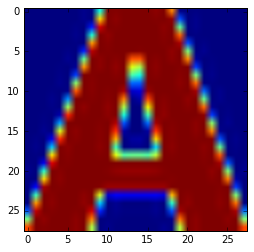

notMNIST_small/B.pickle 392


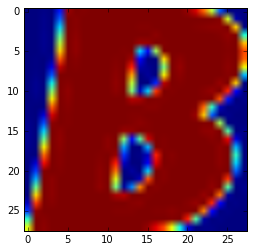

notMNIST_small/C.pickle 1397


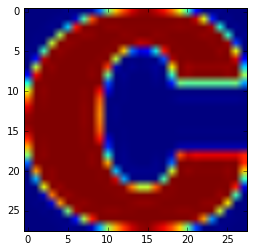

notMNIST_small/D.pickle 77


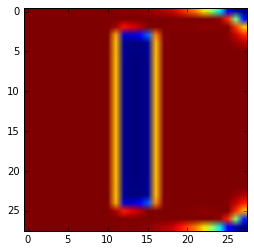

notMNIST_small/E.pickle 150


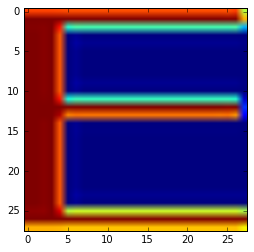

notMNIST_small/F.pickle 545


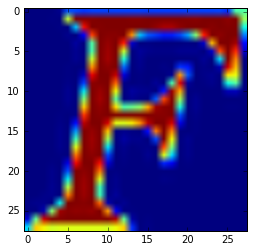

notMNIST_small/G.pickle 63


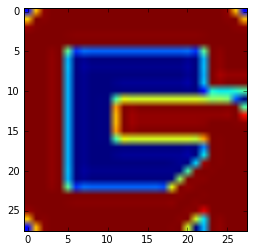

notMNIST_small/I.pickle 1793


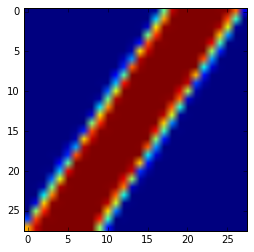

notMNIST_small/G.pickle 1338


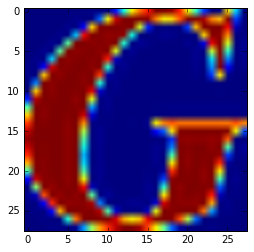

In [5]:
##Problem 2
##Let's verify that the data still looks good. 
##Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

from random import randint

train_datasets = ['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
test_datasets =  ['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']

%matplotlib inline


def showProcessedRandom(dataset_name,n): # shows size of the sample
    with open(dataset_name, 'rb') as f:
        dataset = pickle.load(f)
        indices=np.random.choice(dataset.shape[0], n)
        fig=plt.figure()
        for i in range(n):
            a=fig.add_subplot(1,n,i+1)
            random = randint(0,len(dataset))
            print(dataset_name, random)
            plt.imshow(dataset[random,:,:])
            # a.set_title(chr(labels[indices[i]]+ord('A')))
            #a.axes.get_xaxis().set_visible(False)
            #a.axes.get_yaxis().set_visible(False)
        plt.show()
    f.close()

##for name in train_datasets:
##    showProcessedRandom(name,1) 
for name in test_datasets:
    showProcessedRandom(name,1)




In [46]:
##Problem 3
##Another check: we expect the data to be balanced across classes. Verify that.
##Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.
##Also create a validation dataset for hyperparameter tuning.
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Training data:
B 39057


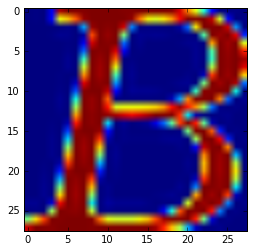

In [47]:
def showSample(dataset, label): # shows size of the sample
    random = randint(0,len(dataset))
    if(len(dataset) != len(label)):
        print("The size of dataset and label doesn't match!")
        return 
    print(str(unichr(ord('A')+label[random])), random)
    plt.imshow(dataset[random,:,:])

##for name in train_datasets:
print('Training data:')
showSample(train_dataset,train_labels)
#print("Validation data:")
#showSample(valid_dataset,valid_labels)
#print("Test data:")
#showSample(test_dataset,test_labels)

In [48]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Training data:
F 192284


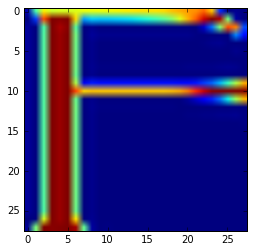

In [9]:
##Problem 4: Convince yourself that the data is still good after shuffling!
print('Training data:')
showSample(train_dataset,train_labels)



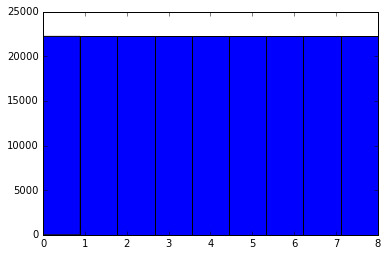

In [10]:
plt.hist(train_labels, len(train_datasets))
plt.show()

In [49]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [51]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [11]:
##Problem 5
##By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! 
##Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, 
##but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.
##Optional questions:
##What about near duplicates between datasets? (images that are almost identical)
##Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

import time
import hashlib

t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

t2 = time.time()

print("Time: %0.2fs" % (t2 - t1))
print("train size: %d " % len(train_labels))
print("test size: %d " % len(test_labels))
print("valid size: %d " % len(valid_labels))
print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())

Time: 2.50s
train size: 200000 
test size: 10000 
valid size: 10000 
valid -> train overlap: 2074 samples
test  -> train overlap: 1488 samples
test  -> valid overlap: 231 samples


In [54]:
##Problem 6
##Let's get an idea of what an off-the-shelf classifier can give you on this data. 
##It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
##Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 
##Hint: you can use the LogisticRegression model from sklearn.linear_model.
##Optional question: train an off-the-shelf model on all the data!

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import zero_one_loss
from sklearn.metrics import classification_report
import random 

sampleSize = [100, 1000, 10000]
model = []
for index, item in enumerate(sampleSize):
    sample = random.sample(range(len(train_labels)), item)
    (train_size, width, height) = train_dataset.shape

    X = np.reshape(train_dataset,(train_size,width*height))[sample]
    Y = train_labels[sample]

    lm = LogisticRegression(random_state=413, C=0.01, penalty='l2',multi_class='multinomial', solver='newton-cg')
    lm.fit(X, Y)
    
    pred = lm.predict(np.reshape(valid_dataset,(valid_size,width*height)))
    
    error_rate = zero_one_loss(valid_labels, pred)
    print ('Error rate: %.2f%%' %(error_rate*100.0))
    ##print (classification_report(test_labels, pred, target_names=list('ABCDEFGHIJ')))
    
    
    model.append(lm) 
    

Error rate: 35.95%
Error rate: 20.18%
Error rate: 16.77%


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import zero_one_loss
from sklearn.metrics import classification_report
import random 

train_sizes = [50, 10000]

for N in train_sizes:
    print ('\nTraining on %d examples' % N)

    model = LogisticRegression(random_state=413, C=0.01, penalty='l2',  multi_class='multinomial', solver='newton-cg')
    
    model.fit(train_dataset[:N].reshape((N, -1)), train_labels[:N])
    
    pred = model.predict(test_dataset.reshape((test_dataset.shape[0], -1)))
    
    error_rate = zero_one_loss(test_labels, pred)
    print ('Error rate: %.2f%%' % (error_rate*100.0))


Training on 50 examples
Error rate: 47.61%

Training on 10000 examples
Error rate: 11.36%
